In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold
from matplotlib import rc
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [2]:
rs = 777
np.random.seed(rs)
obj_bsfldr = '/data/home/shruti/voxceleb/fabnet_corr_300/'

def load_files(in_corr_fldr, sb_fldr, N=None):
    
    # get all the files
    files = [f for f in os.listdir(os.path.join(in_corr_fldr, sb_fldr)) if f.endswith('.npy')]
    print(sb_fldr, len(files))
    if N is not None:
        files = np.random.choice(files, size=np.min([N, len(files)]), replace=False)
    
    out_file = {}
    for f in files:
        out_file[f] = np.reshape(np.load(os.path.join(in_corr_fldr, sb_fldr, f)), (1, -1))
        
    return out_file
    

# train: randm and diff
# test: obama and fake
def get_dataset(dataset, N):

    X_test = None
    y_test = None
    i = 0
    all_keys = list(dataset.keys())
    all_keys = np.sort(all_keys)
    for k in all_keys:
        
        # pick only last 20 files
        sort_keys = np.sort(list(dataset[k].keys()))
        f_arr = np.vstack([dataset[k][l] for l in sort_keys])
                    
        if X_test is None:
            X_test = f_arr
            y_test = np.zeros((len(X_test), ))
        else:
            X_test = np.concatenate((X_test, f_arr), axis=0)
            y_test = np.concatenate((y_test, np.zeros((len(f_arr), ))+i), axis=0)

        i = i+1
        
    y_test = y_test[np.sum(np.isnan(X_test), axis=1)<1].copy()
    X_test = X_test[np.sum(np.isnan(X_test), axis=1)<1, :].copy()
    
    return X_test, y_test

def remove_keys(cur_dict):
    cur_dict.pop('__header__', None)
    cur_dict.pop('__version__', None)
    cur_dict.pop('__globals__', None)
    return cur_dict

#this one combination result
def plot_tsne(X_test, y_test, all_keys):

    #get datasets
    tsne = manifold.TSNE(n_components=2, perplexity=30.0,
                         early_exaggeration=12.0, learning_rate=200.0,
                         n_iter=1000, n_iter_without_progress=300,
                         min_grad_norm=1e-07, metric='euclidean',
                         init='random', verbose=0, random_state=rs,
                         method='barnes_hut', angle=0.5)
    print('tsne train {}'.format(X_test.shape))
    Y = tsne.fit_transform(X_test)

    colormap = plt.cm.tab20 #nipy_spectral #, Set1,Paired
    colorst = [colormap(i) for i in np.linspace(0, 1, len(all_keys))]

    fig, ax = plt.subplots(figsize=(10, 10))
    for k in range(len(all_keys)):
        plt.scatter(Y[y_test==k, 0], Y[y_test==k, 1],
                    label='{}'.format(all_keys[k]), alpha=0.7, facecolors=colorst[k])

    plt.legend(prop={'size': 18}, loc='upper center', 
               bbox_to_anchor=(0.5, 1.2), ncol=3,
               fancybox=True, shadow=False)
    plt.xticks([])
    plt.yticks([])
    ax.axis('off')
    plt.tight_layout(pad=5, h_pad=None, w_pad=None, rect=None)
    plt.show()

In [3]:

# get the training data for PCA
N_train = 3000
dataset = {}
for f in ['bo', 'bs', 'br', 'ew', 'dt_rndm', 'hc', 'jb', 'pb', 'diff_test', 'kh', 'cb']:
    dataset[f] = load_files(obj_bsfldr, f, N_train)
    
X_train, y_train = get_dataset(dataset, N_train)
dataset = []

bo 213222
bs 61025
br 33585
ew 30121
dt_rndm 44332
hc 37409
jb 33699
pb 27939
diff_test 13118
kh 26613
cb 42880


In [4]:
# PCA train
ncomp = 2000
scalar = StandardScaler().fit(X_train)
X_train_norm = scalar.transform(X_train)
pca = PCA(n_components=ncomp, copy=True, whiten=False, 
          svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)
pca = pca.fit(X_train_norm)  


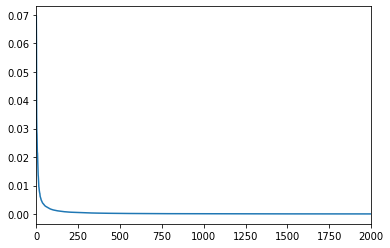

In [5]:
X_train_norm = []
plt.plot(pca.explained_variance_ratio_)
plt.xlim([0, ncomp])
plt.show()

In [6]:
# dictionary
data_keys = ['bo', 'bs', 'br', 'ew', 'dt_rndm', 'hc', 'jb', 'pb', 
             'diff_test', 'kh', 'cb', 'bo_faceswap', 'bs_faceswap', 
             'hc_faceswap', 'ew_faceswap', 'dt_faceswap', 'bo_UWfake']


# get the training data for PCA
N_test = 1000
dataset = {}
for f in data_keys:
    dataset[f] = load_files(obj_bsfldr, f, N_test)
    
X_test, y_test = get_dataset(dataset, N_test)
dataset = []

X_test_norm = scalar.transform(X_test)
X_test_pca = pca.transform(X_test_norm)


bo 213222
bs 61025
br 33585
ew 30121
dt_rndm 44332
hc 37409
jb 33699
pb 27939
diff_test 13118
kh 26613
cb 42880
bo_faceswap 1738
bs_faceswap 970
hc_faceswap 1867
ew_faceswap 301
dt_faceswap 2510
bo_UWfake 14672


tsne train (16259, 2000)


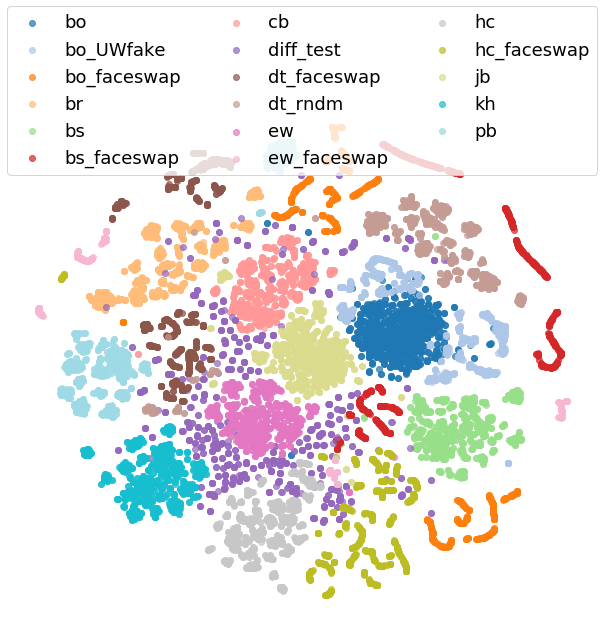

In [7]:
all_keys = data_keys
all_keys = np.sort(all_keys)

plot_tsne(X_test_pca, y_test, all_keys)

In [8]:
import utils as u

pca_dict = {'pca_model': pca, 'pca_scalar': scalar}
u.save_obj(pca_dict, '.', 'pca_model_300_190')

In [9]:
def load_files_with_pca(in_corr_fldr, sb_fldr, pca_model):
    
    # get all the files
    files = [f for f in os.listdir(os.path.join(in_corr_fldr, sb_fldr)) if f.endswith('.npy')]
    print(sb_fldr, len(files))
    out_file = {}
    i = 0
    for f in files:
        cur_feat = np.reshape(np.load(os.path.join(in_corr_fldr, sb_fldr, f)), (1, -1))
        if np.sum(np.isnan(cur_feat))>1:
            continue
            
        i = i+1
        out_file[f] = pca_model['pca_model'].transform(pca_model['pca_scalar'].transform(cur_feat))
    
    print(i)
    return out_file

In [10]:
import utils as u

pca_dict = u.load_obj('.', 'pca_model_300_190')
data_keys = ['bo', 'bs', 'br', 'ew', 'dt_rndm', 'hc', 'jb', 'pb', 
             'diff_test', 'kh', 'cb', 'bo_faceswap', 'bs_faceswap', 
             'hc_faceswap', 'ew_faceswap', 'dt_faceswap', 'bo_UWfake', 
             'bo_imposter', 'bs_imposter', 
             'hc_imposter', 'ew_imposter', 'dt_imposter', 'trump_fake']


for f in data_keys:
    
    f_feat = load_files_with_pca(obj_bsfldr, f, pca_dict)
    u.save_obj(f_feat, 'obj/fabnet_corr_300_190', f)

bo 213222
213213
bs 61025
61025
br 33585
33585
ew 30121
29806
dt_rndm 44332
44332
hc 37409
37409
jb 33699
33699
pb 27939
27939
diff_test 13118
13118
kh 26613
26613
cb 42880
42880
bo_faceswap 1738
1738
bs_faceswap 970
970
hc_faceswap 1867
1867
ew_faceswap 301
301
dt_faceswap 2510
2510
bo_UWfake 14672
14672
bo_imposter 2208
2208
bs_imposter 1549
1549
hc_imposter 2011
2011
ew_imposter 301
301
dt_imposter 2510
2510
trump_fake 113
113
